# Linear Regression

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype

In [2]:
na = '<NA>'

df = pd.read_csv(r'../data_file/selected_data.csv')
df = df[df.loc[:,] != na].drop(columns = [df.columns[0]])

obj_type, rooms, surface, zip_code_2_digits, zip_code_3_digits, canton, year_built, year_renovated, distance_to_station, price_square_metres, price = df.columns

target_frame = df.loc[:, [price]]

C:\Users\Lukas\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


#### Helper Functions

In [3]:
def frame_to_numeric(frame):
    """transforms every value of a data frame to numeric if possible"""
    for column in frame.columns:
        try:
            frame.loc[:, column] = pd.to_numeric(frame.loc[:, column])
        except:
            continue #nothing toDo here
    return frame

df = frame_to_numeric(df)

In [4]:
def rooms_surface_mean(df):
    df = frame_to_numeric(df.loc[:, [rooms, surface]].dropna())
    return df.groupby(rooms).mean()

def add_rooms(row, df_rooms_mean):
    return df_rooms_mean.loc[row[rooms]]

def add_nearest_rooms_by_surface(df):
    """completes the dataframe rooms by the nearest neighbour based on the surface mean distance
    and the surface of the missing rooms objects"""
    df = df.reset_index(drop = True)
    df_rooms_mean = rooms_surface_mean(df)
    df_rooms_missing = df[df.loc[:, rooms].isna()].loc[:, [surface]]
    dist = cdist(df_rooms_missing, df_rooms_mean) #computes the distance between each pair of surface
    idx = np.argsort(dist) #gets sorted index (most left = lowest distance index)
    rooms_class = idx[:,0] #gets the room class (index)
    df_rooms_missing.loc[:, rooms] = rooms_class
    df_rooms_mean = df_rooms_mean.reset_index()
    df_rooms_missing.loc[:, rooms] = df_rooms_missing.apply(lambda row: add_rooms(row, df_rooms_mean), axis = 1)
    df.loc[df_rooms_missing.index, rooms] = df_rooms_missing.loc[:, rooms] #appends the missing rooms to the real data-frame
    return df

df = add_nearest_rooms_by_surface(df)

In [10]:
def add_surface(row, df_rooms_mean):
    return df_rooms_mean.loc[row[surface]]

def add_surface_mean_by_nearest_rooms(df):
    """completes the dataframe surface by the nearest neighbour surface mean based on the room distance
    of the missing surface objects"""
    df = df.reset_index(drop = True)
    df_rooms_mean = rooms_surface_mean(df).reset_index()
    df_surface_missing = df[df.loc[:, surface].isna()].loc[:, [rooms]]
    dist = cdist(df_surface_missing, df_rooms_mean.loc[:, [rooms]]) #computes the distance between each pair of rooms
    idx = np.argsort(dist) #gets sorted index (most left = lowest distance index)
    surface_class = idx[:,0] #gets the surface class (index)
    df_surface_missing.loc[:, surface] = surface_class
    df_surface_missing.loc[:, surface] = df_surface_missing.apply(lambda row: add_surface(row, df_rooms_mean), axis = 1)
    df.loc[df_surface_missing.index, surface] = df_surface_missing.loc[:, surface]
    return df


df = add_surface_mean_by_nearest_rooms(df)

In [72]:
def handle_missing_numeric_feature(df, feature, na):
    """this function completes the missing vlaues of a data-frame with the median of the given numeric feature
    it adds a new column `feature`+'_'+`na` at the end of the feature index,
    which is going to be '1' if the value of the data object is missing and '0' otherwise 
    """
    df_copy = df.copy()
    na_index = pd.Index(df_copy.columns).get_loc(feature) + 1
    column = df_copy.loc[:, feature]
    column = column.replace(np.nan, na, regex = True)
    artificial_column = [1 if x == na else 0 for x in column] #comprehensions
    df.insert(na_index, feature+'_'+na, artificial_column)
    
    na_indexes = column[column == na].index
    feature_median = df_copy.loc[:, feature].median()
    df.loc[na_indexes, feature] = feature_median
    return df

def missing_numerical_features_controller(df, features, na):
    """this function just calls the :func:`handle_missing_numeric_feature` for each given feature"""
    for feature in features:
        df = handle_missing_numeric_feature(df, feature, na)
    return df

In [162]:
def one_hot_encoding(df, na, feature_name):
    """performs a complete one-hit encoding on the specified feature of the dataframe
    adds a the prefix '_' to each unique encoding class
    separates automatically all missing values as it's own category named: feature_name+'_'+na
    returns: 
    -encoded data-frame
    -categories of the variable as an array
    """
    enc = OneHotEncoder()
    df = df.copy()
    delimiter = feature_name + '_'
    na_delimiter = '_' + na
    
    if df.loc[:, [feature_name]].isnull().values.any():
        df.loc[:, feature_name] = df.loc[:, feature_name].replace(np.nan, feature_name + na_delimiter, regex = True)

    selected_frame = delimiter + df.loc[:, feature_name].astype(str).to_frame()
    encoded_array = enc.fit_transform(selected_frame).toarray()
    categories = enc.categories_[0]    
    df_enc = pd.DataFrame(data = encoded_array, columns = categories)
    categories_sorted = np.sort(categories)
    df_enc = df_enc[categories_sorted]
    df = df.drop(columns = [feature_name])
    df[categories_sorted] = df_enc
    return df, categories_sorted

def get_prepared_df(df, na, target_variable, categorical_features = [], numerical_features = []):
    """returns the data frame with the specified encoded features and the corresponding generated categories"""
    df_selected = df.loc[:, (numerical_features + categorical_features)]
    categories = {}
    for feature in categorical_features:
        df_selected, categories[feature] = one_hot_encoding(df_selected, na, feature)
    df_selected[target_variable] = df.loc[:, target_variable]
    return df_selected, categories

def normalize_df(df, features):
    """normalizes the given numerical sample to mean 0 and std 1"""
    df[features] = (df.loc[:, features] - df.loc[:, features].mean(axis = 0) / df.loc[:, features].std(axis = 0))
    return df

## Linear Regression

In [163]:
def launch_regression(X_train, y_train, X_test = None, y_test = None):
    lr = LinearRegression()
    #y = np.log10(y_train)
    #y = np.sqrt(y_train)
    lr.fit(X_train, y_train)
    score = lr.score(X_train, y_train)
    predicted = lr.predict(X_train)
    residuals = y_train - predicted
    intercept = lr.intercept_
    print('r^2 score: ', score)
    
    fig, ax = plt.subplots(figsize=(15,8))
    _ = ax.plot(predicted, residuals, 'o', markeredgecolor='black', color='blue', alpha=0.4)
    _ = ax.grid(True)
    _ = ax.set_title('Tukey-Ascombe Plot')
    _ = ax.set_ylabel('$r$')
    _ = ax.set_xlabel('$\hat y$')
    

r^2 score:  0.6997268935076361


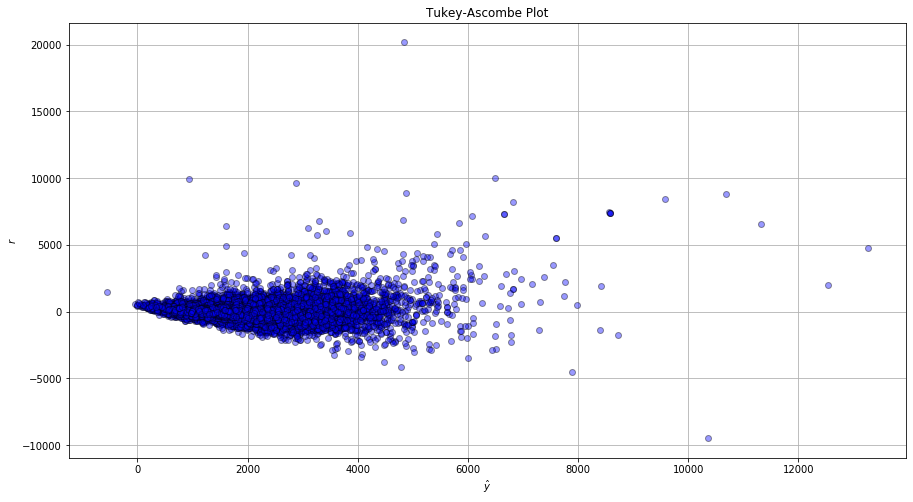

In [173]:
def init(df, na):
    #initialization and declaration of the variables
    categorical_features = [obj_type, canton, zip_code_2_digits, zip_code_3_digits]
    complete_numerical_features = [surface, rooms, distance_to_station]
    missing_numerical_features = [year_built, year_renovated]
    target_variable = [price]
    numerical_features = (complete_numerical_features + missing_numerical_features)
    
    #preprocessing & launch regression
    df_prepared, categories = get_prepared_df(df, na, target_variable, categorical_features, numerical_features)
    df_prepared = missing_numerical_features_controller(df_prepared, missing_numerical_features, na)
    #df_prepared = normalize_df(df_prepared, numerical_features)
    
    #separate features
    df_target_variable = df_prepared.loc[:, target_variable]
    df_input = df_prepared.drop(columns = target_variable)
    
    #test_size = 1 if the intention is to train on the full data set
    X_train, X_test, y_train, y_test = train_test_split(df_input, df_target_variable, test_size = 1, random_state = 42)
    
    launch_regression(X_train = X_train, y_train = y_train)

init(df, na)